## Overview

In this notebook, we will look at the artist tag information in the subset of the Million Song Dataset. 

We will see if this information can be used to predict a songs hotness (or 'song_hotttnesss' as it is called in the dataset). The artist tags will be changed into stemmed form, and we will use both classification as well as regression models to check the usefulness of this information in the dataset.

### Preparation

In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [271]:
import numpy as np
import pandas as pd
import re
import operator
import matplotlib.pyplot as plt
from functools import reduce
from collections import Counter

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
    
from keras.layers.convolutional import MaxPooling1D#, MaxPooling2D
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Conv1D, BatchNormalization, Activation, Dropout, GRU
from keras.optimizers import SGD, Adam, RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend

In [4]:
#Increase notebook size to take the full width of the screen

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Load dataset

In [56]:
# Load the selected dataset, and check for missing 'song hotness'

subset_full = pd.read_csv('subset_full.csv')
subset_full = subset_full.drop(columns=['Unnamed: 0'])
missing = subset_full['song_hotttnesss'].isna().sum() / len(subset_full)*100
print('Number of songs missing "song hotness": {}%'.format(np.around(missing, 1)))
print(subset_full.shape)

Number of songs missing "song hotness": 43.5%
(10000, 54)


In [57]:
# Select only the data with song_hotness, and confirm

subset_full = subset_full.dropna(subset = ['song_hotttnesss'])
missing = subset_full['song_hotttnesss'].isna().sum() / len(subset_full)*100
print('Number of songs missing "song hotness": {}%'.format(np.around(missing, 1)))
print(subset_full.shape)

Number of songs missing "song hotness": 0.0%
(5648, 54)


In [58]:
# Select only the data artist terms, as this is what will be used in this notebook

subset_full = subset_full.dropna(subset = ['artist_terms'])
subset_full.shape

(5648, 54)

In [59]:
# Remove the columns that are not related to this. Most are covered in other notebooks

tagrelated_columns = ['song_hotttnesss','track_id', 'artist_terms', 'artist_terms_freq', 'artist_terms_weight']
data = subset_full[tagrelated_columns]
data = data.reset_index().drop(columns=['index'])

# Start process of splitting up terms
data['artist_terms'] = data['artist_terms'].str.split('\'')
data['artist_terms'] = data['artist_terms'].str[1:]

In [60]:
# Confirm data

data.head()

,song_hotttnesss,track_id,artist_terms,artist_terms_freq,artist_terms_weight
0,0.602120,TRAAAAW128F429D538,"[hip hop, , underground rap, , g funk, , al...",[1. 0.77613623 0.72966979 0.68301072 0...,[1. 0.89793596 0.88426185 0.84262975 0...
1,0.604501,TRAAAFD128F92F423A,"[pop punk, , ska punk, , breakcore, , alter...",[0.8872883 0.79020373 0.79020373 0.79020373 0...,[1. 0.96090574 0.95923662 0.94674975 0...
2,0.265861,TRAAARJ128F9320760,"[new wave, , progressive rock, , space rock,...",[0.95976625 0.97039005 0.82199342 0.82199342 0...,[1. 0.98696192 0.98306453 0.96580916 0...
3,0.000000,TRAAAVO128F93133D4,"[alternative rock, , indie rock, , rock, , ...",[0.95608075 0.92130641 1. 0.68760239 0...,[1. 0.95787086 0.95089056 0.93066094 0...
4,0.265861,TRAABCL128F4286650,"[ccm, , religious music, , los angeles, , c...",[1. 0.87337884 0.82439509 0.82439509 0...,[1. 0.90446866 0.86751209 0.84218695 0...


In [61]:
# Split the artist terms into separate keywords, as well as create list of all possible keywords

data['terms_count'] = 0
data = data.astype('object')
all_terms = []

for i,x in enumerate(data.iterrows()):
    data['artist_terms'].astype(object)
    temp = []
    for y in x[1][2]:
        if re.search('[a-zA-Z]', y):
            temp.append(y)
    data.loc[i,'artist_terms'] = temp
    data.loc[i,'terms_count'] = len(temp)
    all_terms.append(temp)

In [62]:
# Each song has a separate list within a list of its terms
# Create one large list of all possible terms 

flat_all_terms = reduce(operator.concat, all_terms)

In [63]:
# Create a counter of how many times each term is used

count_all_terms = Counter(flat_all_terms)
print("There are a total of {} different artist terms used in the dataset".format(len(count_all_terms)))

There are a total of 3100 different artist terms used in the dataset


### Select the appropriate number of terms to test for

There are a total of 3100 artist terms in use. Some terms are used very rarely, and hence do most likely not add value to our models.

Let us first look at the distribution of the terms:

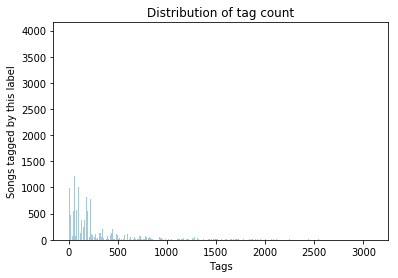

In [64]:
keys = count_all_terms.keys()
y_pos = np.arange(len(keys))
x_pos = count_all_terms.values()

plt.bar(y_pos, x_pos, align='center', alpha=0.4)
plt.xlabel('Tags')
plt.ylabel('Songs tagged by this label')
plt.title('Distribution of tag count')

plt.show()

There are a number of tags that are used for many songs, while there is a large tail of terms not used very often. 

Let us limit the terms to the ones used for more than 20 songs, and we will see the distribution looks better:

In [65]:
min_threshold = 20

for key, cnts in list(count_all_terms.items()):   
    if cnts < min_threshold:
        del count_all_terms[key]
        
print("There is now {} artist terms".format(len(count_all_terms)))

There is now 824 artist terms


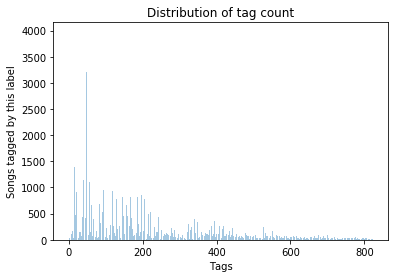

In [66]:
keys = count_all_terms.keys()
y_pos = np.arange(len(keys))
x_pos = count_all_terms.values()

plt.bar(y_pos, x_pos, align='center', alpha=0.4)
plt.xlabel('Tags')
plt.ylabel('Songs tagged by this label')
plt.title('Distribution of tag count')

plt.show()

### Stemming

To ensure that the artist terms are as common as possible among the different songs, do we implement stemming. 

Let's build a dictionary of all the artist terms used in more than 20 songs, in stemmed form:

In [67]:
ps = PorterStemmer()

temp = []
stem_dict = {}
for w in count_all_terms.keys():
    s = ps.stem(w)
    temp.append(s)
    stem_dict[w] = s

We need to put the stemmed forms back into the dataset we are working with:

In [68]:
data = data.astype('object')

for i,x in enumerate(data.iterrows()):
    temp = []
    for y in x[1][2]:
        if y in stem_dict.keys():
            temp.append(stem_dict[y])

    data.loc[i,'artist_terms'] = temp

And we need to make a one hot encoded version of the dataframe, that is more suitable for the models we want to run: 

In [69]:
data2 = data.copy()
df = pd.DataFrame()
mlb = MultiLabelBinarizer()
data3 = data.join(pd.DataFrame(mlb.fit_transform(data2.pop('artist_terms')),
                          columns=mlb.classes_,
                          index=data2.index))
data3 = data3.drop(columns=['\n "rock ',' "rock '])

Let's split the data into target and predictor sets:

In [70]:
y = data3['song_hotttnesss']

x = data3.drop(columns=['song_hotttnesss','track_id', 'artist_terms_freq', 'artist_terms_weight', 'artist_terms'])

x = StandardScaler().fit_transform(x)

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Let us also create two sets; one for classification, and one for regressions:

In [71]:
# For regression
y_regression = y.copy()

In [41]:
# For classification
# Simplify by only setting top 25% of song_hotness to be "hot" and the rest "not"

def convert_y_to_categorical(cutoff = 0.75):
    threshold = y.quantile(cutoff)
    Y = [0 if i < threshold else 1 for i in y]
    return np.array(Y)
y = convert_y_to_categorical()
y = y.astype('int')

print("{} % of the songs are classified as hot, while the rest is not".format(y.mean()*100))

25.106232294617563 % of the songs are classified as hot, while the rest is not


In [42]:
# Split into training and test sets

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5083, 484), (5083,), (565, 484), (565,))

[1.83227283e-02 1.69976216e-02 1.41318695e-02 1.25853669e-02
 1.14506192e-02 1.10292001e-02 1.04128285e-02 9.79154869e-03
 9.30023170e-03 8.83456183e-03 8.69423881e-03 8.25800639e-03
 8.01847606e-03 7.37551840e-03 6.88763621e-03 6.46070280e-03
 6.19629087e-03 6.05676275e-03 6.03135022e-03 5.74349320e-03
 5.56719892e-03 5.43279933e-03 5.31229414e-03 5.21603198e-03
 5.06083790e-03 4.92498483e-03 4.76144622e-03 4.70667219e-03
 4.61824873e-03 4.52994355e-03 4.40885966e-03 4.37440092e-03
 4.25313672e-03 4.22619525e-03 4.18366661e-03 4.14083065e-03
 4.07223087e-03 3.99818305e-03 3.98368489e-03 3.84312351e-03
 3.79814915e-03 3.75993455e-03 3.71886605e-03 3.66226059e-03
 3.57864802e-03 3.56433788e-03 3.55704986e-03 3.47939605e-03
 3.44515461e-03 3.41155336e-03 3.37598518e-03 3.34974143e-03
 3.33522468e-03 3.30370632e-03 3.25865858e-03 3.22674737e-03
 3.21205648e-03 3.19025610e-03 3.16407839e-03 3.10887906e-03
 3.07348343e-03 3.04897613e-03 3.02931199e-03 2.99449497e-03
 2.95754719e-03 2.929862

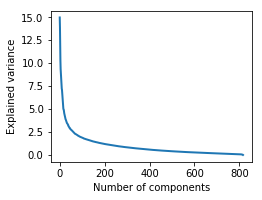

In [264]:
# First, check PCA if any predictors are very dominating
pca_all = PCA()
pca_all.fit(x_train)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
print(pca_all.explained_variance_ratio_)

## Classifications

### First, let's run a number of standard algoritms and see what we get:

In [169]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [170]:
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        clf.fit(x_train, y_train)
        score = clf.score(x_test, y_test)
        print("The test score for the {} is {:f}".format(name, score))

The test score for the Nearest Neighbors is 0.789381
The test score for the Linear SVM is 0.775221
The test score for the RBF SVM is 0.803540
The test score for the Gaussian Process is 0.800000
The test score for the Decision Tree is 0.789381
The test score for the Random Forest is 0.757522
The test score for the Neural Net is 0.785841
The test score for the AdaBoost is 0.784071
The test score for the Naive Bayes is 0.527434
The test score for the QDA is 0.745133


/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Let us select two of the algoritms above, and run them with cross validation

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate plot of the test and training learning curve.

    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# First model
title = "Learning Curves KNeighborsClassifier K=3"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = KNeighborsClassifier(3)
plot_learning_curve(estimator, title, x_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

# Second model
title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, x_train, y_train, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

### Let us then try neural networks, and see if the results may improve

In [127]:
# Set random seed for reproducibility

seed = 7
numpy.random.seed(seed)

In [132]:
# Create a baseline model, to see what results we may get

def create_baseline():
    model = Sequential()
    model.add(Dense(817, input_dim=817, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [135]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=5, batch_size=5, verbose=1)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)
print("A mean of %.2f%%  with a standard deviation of %.2f%%" % (results.mean()*100, results.std()*100))

Epoch 1/5
3388/3388 [==============================] - 3s 907us/step - loss: 0.6851 - acc: 0.7583
Epoch 2/5
3388/3388 [==============================] - 2s 736us/step - loss: 0.3755 - acc: 0.8442
Epoch 3/5
3388/3388 [==============================] - 3s 812us/step - loss: 0.3483 - acc: 0.8536
Epoch 4/5
3388/3388 [==============================] - 3s 753us/step - loss: 0.3156 - acc: 0.8687
Epoch 5/5
1695/1695 [==============================] - 1s 380us/step
Epoch 1/5
3389/3389 [==============================] - 3s 966us/step - loss: 0.6673 - acc: 0.7572
Epoch 2/5
3389/3389 [==============================] - 3s 760us/step - loss: 0.3709 - acc: 0.8472
Epoch 3/5
3389/3389 [==============================] - 3s 744us/step - loss: 0.3327 - acc: 0.8687
Epoch 4/5
3389/3389 [==============================] - 3s 741us/step - loss: 0.3190 - acc: 0.8743
Epoch 5/5
1694/1694 [==============================] - 1s 422us/step
Epoch 1/5
3389/3389 [==============================] - 3s 933us/step - loss: 0

In [173]:
# Create a larger model, to see if the results may be improved
def create_larger():
    model = Sequential()
    model.add(Dense(817, input_dim=817, kernel_initializer='normal', activation='relu'))
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_larger, epochs=5, batch_size=5, verbose=1)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x_train, y_train, cv=kfold)
print("A mean of %.2f%% with a standard deviation of %.2f%%" % (results.mean()*100, results.std()*100))

Epoch 1/5
4065/4065 [==============================] - 6s 2ms/step - loss: 0.4690 - acc: 0.7934
Epoch 2/5
4065/4065 [==============================] - 4s 965us/step - loss: 0.3545 - acc: 0.8399
Epoch 3/5
4065/4065 [==============================] - 4s 930us/step - loss: 0.3016 - acc: 0.8659
Epoch 4/5
4065/4065 [==============================] - 4s 1ms/step - loss: 0.2537 - acc: 0.8792
Epoch 5/5
1018/1018 [==============================] - 1s 1ms/step
Epoch 1/5
4066/4066 [==============================] - 7s 2ms/step - loss: 0.4722 - acc: 0.7863
Epoch 2/5
4066/4066 [==============================] - 4s 935us/step - loss: 0.3566 - acc: 0.8433
Epoch 3/5
4066/4066 [==============================] - 4s 1ms/step - loss: 0.2954 - acc: 0.8556
Epoch 4/5
4066/4066 [==============================] - 4s 935us/step - loss: 0.2494 - acc: 0.8743
Epoch 5/5
1017/1017 [==============================] - 2s 2ms/step
Epoch 1/5
4067/4067 [==============================] - 7s 2ms/step - loss: 0.4633 - acc: 0

## Regression

In [72]:
# Split into training and test sets

x_train, x_test, y_train, y_test = train_test_split(x, y_regression, test_size = 0.2, random_state = 42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4518, 817), (4518,), (1130, 817), (1130,))

### First, let us try two simple models based on Keras

In [73]:
# define base model
def baseline_model():
    model = Sequential()
    model.add(Dense(817, input_dim=817, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [74]:
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=5, verbose=1)

In [253]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)
print("A mean of %.2f% with a standard deviation of %.2f% using MSE" % (results.mean(), results.std()))

Epoch 1/10
4066/4066 [==============================] - 4s 1ms/step - loss: 1.8175
Epoch 2/10
4066/4066 [==============================] - 3s 719us/step - loss: 0.0943
Epoch 3/10
4066/4066 [==============================] - 3s 720us/step - loss: 0.0579
Epoch 4/10
4066/4066 [==============================] - 3s 773us/step - loss: 0.0568
Epoch 5/10
4066/4066 [==============================] - 3s 753us/step - loss: 0.0806
Epoch 6/10
4066/4066 [==============================] - 3s 717us/step - loss: 0.0946
Epoch 7/10
4066/4066 [==============================] - 3s 761us/step - loss: 0.1088
Epoch 8/10
4066/4066 [==============================] - 3s 740us/step - loss: 0.1180
Epoch 9/10
4066/4066 [==============================] - 3s 716us/step - loss: 0.1048
Epoch 10/10
452/452 [==============================] - 1s 2ms/step
Epoch 1/10
4066/4066 [==============================] - 4s 1ms/step - loss: 1.5620
Epoch 2/10
4066/4066 [==============================] - 3s 720us/step - loss: 0.1198
Ep

ValueError: unsupported format character 'w' (0x77) at index 16

In [78]:
# define the model
def larger_model():
    model = Sequential()
    model.add(Dense(817, input_dim=817, kernel_initializer='normal', activation='relu'))
    model.add(Dense(25, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [252]:
np.random.seed(seed)
estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=10, batch_size=5, verbose=1)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(pipeline, x_train, y_train, cv=kfold)
print("A mean of %.2f with a standard deviation of %.2f using MSE" % (results.mean(), results.std()))

Epoch 1/10
3614/3614 [==============================] - 5s 1ms/step - loss: 0.0491
Epoch 2/10
3614/3614 [==============================] - 3s 929us/step - loss: 0.0342
Epoch 3/10
3614/3614 [==============================] - 3s 965us/step - loss: 0.0293
Epoch 4/10
3614/3614 [==============================] - 4s 990us/step - loss: 0.0260
Epoch 5/10
3614/3614 [==============================] - 3s 930us/step - loss: 0.0230
Epoch 6/10
3614/3614 [==============================] - 4s 972us/step - loss: 0.0212
Epoch 7/10
3614/3614 [==============================] - 4s 980us/step - loss: 0.0196
Epoch 8/10
3614/3614 [==============================] - 3s 931us/step - loss: 0.0179
Epoch 9/10
3614/3614 [==============================] - 3s 963us/step - loss: 0.0178
Epoch 10/10
904/904 [==============================] - 1s 742us/step
Epoch 1/10
3614/3614 [==============================] - 5s 1ms/step - loss: 0.0488
Epoch 2/10
3614/3614 [==============================] - 4s 995us/step - loss: 0.0340


### A model using gradient boosting

The MSE of this model is 0.0416


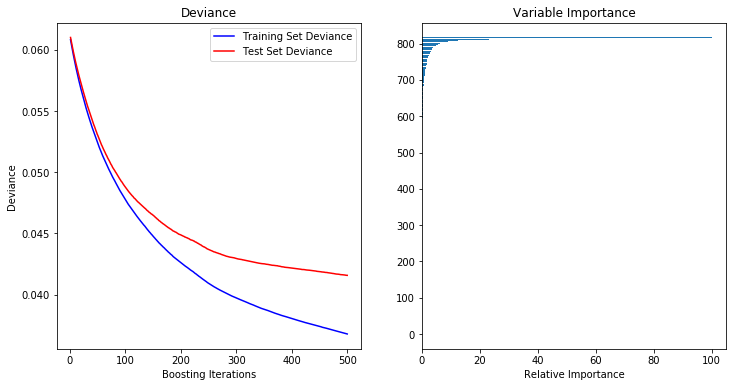

In [273]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(x_train, y_train)
mse = mean_squared_error(y_test, clf.predict(x_test))
print("The MSE of this model is %.4f" % mse)

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(x_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [345]:
# Restructure the predicted results to enable us to illustrate it

predicted = pd.Series(clf.predict(x_test))
result = pd.DataFrame(predicted)
df = pd.concat([result, y_test.reset_index()], ignore_index=True, axis=1)
df = df.drop(columns=[1])
df = df.rename(columns={0: 'predicted', 2: 'true'})
df = df.sort_values('true')
df = df.reset_index()
df = df.drop(columns=['index'])

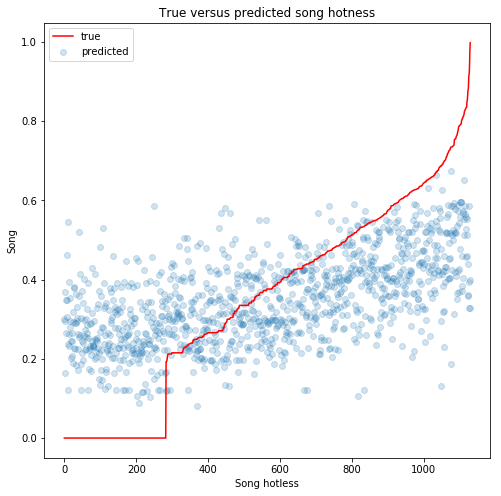

In [349]:
# Let us create an illustration 

plt.figure(figsize=(8, 8))
plt.scatter(df.index, df['predicted'], alpha=0.2)
plt.plot(df.index, df['true'], color='red')
plt.xlabel('Song hotless')
plt.ylabel('Song')
plt.title("True versus predicted song hotness")
plt.legend()
plt.show()

The predicted song hotness increase slightly as the true song hotness increase. However, this effect is very weak. The model does not predict any songs above approximately 0.65, while we in the classification section only classified songs with a score above 0.75 as hot. Hence, the regression model have not classified any songs as hot according to our earlier definition.

## Conclution

We have checked if the artist tags can be used to predict a songs hotness. 

In conclution, we have achieved decent results for classification purposes, but not so decent results for the regressions. 

When using classification, we divided the songs into 'hot or not' by using a 0.75 treshold. In other words, a model just predicting all songs as 'not' would acheive a successrate of 75 %. Certain of our classification-models have achieved a successrate towards 90 percent, which clearly is better than the baseline. However, it also shows that artist tags by using a model just using artist tags by itself is not enough to get the desired result from a model.

When it comes to the regression-models, they did not achieve satisfactory results. We can see that there is a correlation between the songs hotness and the predicted hotness, but this correlation is too weak to be useful.